origin: http://pytorch.org/tutorials/beginner/pytorch_with_examples.html  
translator: Hongpu Liu

In [1]:
%matplotlib inline
from __future__ import print_function

# 用TensorFlow的静态图实现神经网络
PyTorch的自动求导看上去与TensorFlow非常相似：在两个框架中，我们都要定义一个计算图，然后自动微分来计算梯度。二者最大的差异在于：TensorFlow的计算图是**静态的**，而PyTorch的计算图是**动态的**。

在TensorFlow中，首先定义个计算图，然后给定不同的输入数据来反复运行这一计算图。而在PyTorch中，每次前馈都会定义一个新的计算图。

静态图的优点是可以进行预先优化，例如为了效率而融合若干操作，或者为了在多个GPU或主机上运行提供分布策略。如果一个计算图被反复的执行，那么预优化所用的潜在开销，会在反复运行该计算图的过程中“分期偿还”。

静态图与动态图的另一个差别在于**控制流**。对于某些模型，我们希望对于不同的数据执行不同的计算。例如在循环神经网络中，对于不同的数据要展开的时间步数是不同的，这个展开可以用循环来实现。在静态图中，循环需要构建为图的一个部分，因此TensorFlow提供了诸如**tf.scan**的功能，用来将循环嵌入到图当中。对于动态图这种情况很容易实现，由于计算图是运行时创建的，因此在处理不同的数据时，可以直接使用控制流语句执行计算。

为了与之前的PyTorch自动求导的例子进行比较，用TensorFlow实现一个两层的神经网络：

In [2]:
import tensorflow as tf
import numpy as np

# N     ：样本的数量，本例采用批量梯度下降，每次训练使用全部的样本
# D_in  ：输入特征的维度
# H     ：隐层神经元的数量
# D_out ：输出层维度
N, D_in, H, D_out = 64, 1000, 100, 10

# 首先，配置计算图

# 为输入和输出创建PlaceHolder，在每次执行计算图时会把真实的数据填充到里面
x = tf.placeholder(tf.float32, shape=(None, D_in))
y = tf.placeholder(tf.float32, shape=(None, D_out))

# 为权重创建变量并随机初始化。TensorFlow的变量会在执行计算图时在内（显）存中保持存储。
# w1 = tf.Variable(tf.random_normal((D_in, H)))
# w2 = tf.Variable(tf.random_normal((H, D_out)))
# 注：原有的例子在我的环境中不会收敛，因此调整了初始权重
w1 = tf.Variable(tf.random_normal((D_in, H)) * 0.9)
w2 = tf.Variable(tf.random_normal((H, D_out)) * 0.9)

# 前向传播：用TensorFlow中的Tensor运算来计算要预测的y值。
# 值得注意的是，下面的代码并不会执行任何的数值运算，仅仅是用来构建未来要计算的计算图。
h = tf.matmul(x, w1)
h_relu = tf.maximum(h, tf.zeros(1))
y_pred = tf.matmul(h_relu, w2)

# 用TensorFlow中的Tensor运算来计算loss
loss = tf.reduce_sum((y_pred - y) ** 2.0)

# 计算loss关于权重w1和w2的梯度
grad_w1, grad_w2 = tf.gradients(loss, [w1, w2])

# 用梯度下降法更新权重。为了能够更新权重，需要在执行计算图时计算new_w1和new_w2的值。
# 注意：在TensorFlow当中权重的更新是计算图的一个部分；
# 而在PyTorch中权重的更新是在计算图之外完成的。
learning_rate = 1e-6
new_w1 = w1.assign(w1 - learning_rate * grad_w1)
new_w2 = w2.assign(w2 - learning_rate * grad_w2)

# 注意：在这之前，已经完成了计算图的构建。

# 接下来要进入一个TensorFlow的Session来真正计算这个计算图
with tf.Session() as sess:
    # 运行该图一次，以初始化变量w1和w2
    sess.run(tf.global_variables_initializer())
    
    # 创建numpy数组来保存实际的输入数据x和目标数据y
    x_value = np.random.randn(N, D_in)
    y_value = np.random.randn(N, D_out)
    
    losses = []
    
    for _ in range(500):
        # 反复执行计算图。
        # 每次执行都需要传入feed_dict参数，将x_value绑定到x，y_value绑定到y。
        # 每次执行计算图，需要计算loss、new_w1和new_w2，这些值将以numpy数组的形式返回。
        loss_value, w1_, w2_ = sess.run([loss, new_w1, new_w2],
                                   feed_dict={x: x_value, y: y_value})
        print(loss_value)
        losses.append(loss_value)

2.46969e+07
1.75285e+07
1.28569e+07
9.68395e+06
7.43188e+06
5.79809e+06
4.5795e+06
3.6574e+06
2.94617e+06
2.39239e+06
1.95555e+06
1.60889e+06
1.33081e+06
1.10707e+06
925380.0
777255.0
655823.0
555981.0
473404.0
404885.0
347710.0
299894.0
259705.0
225828.0
197114.0
172731.0
151917.0
134091.0
118761.0
105535.0
94078.2
84116.4
75416.3
67798.3
61101.9
55199.4
49978.3
45347.1
41229.9
37559.0
34272.9
31327.2
28679.8
26294.7
24141.4
22193.0
20428.4
18827.4
17372.0
16046.1
14836.2
13730.5
12718.2
11790.5
10939.0
10157.3
9438.59
8776.88
8167.06
7605.06
7085.61
6605.39
6162.02
5751.84
5371.64
5019.09
4692.02
4388.35
4106.13
3843.8
3599.76
3372.47
3160.77
2963.5
2779.52
2607.86
2447.68
2298.12
2158.39
2027.77
1905.62
1791.35
1684.41
1584.4
1490.82
1403.15
1321.0
1244.02
1171.78
1103.98
1040.37
980.653
924.57
871.868
822.346
775.776
732.0
690.834
652.129
615.677
581.362
549.06
518.638
489.975
462.985
437.539
413.558
390.956
369.649
349.557
330.602
312.714
295.838
279.912
264.875
250.681
237.273
22

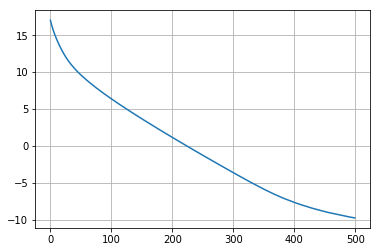

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.log(np.array(losses)))
plt.grid()